# Customer Clustering 

What kind of customers spend the most? What kind of customer groups are there in the business? Any people who spend the most or least? How could we target different customer groups differently per email, ads etc? This code aims to answers those questions. 

In [1]:
import pandas as pd 

df = pd.read_csv('Customers.csv')
df

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...,...
1995,1996,Female,71,184387,40,Artist,8,7
1996,1997,Female,91,73158,32,Doctor,7,7
1997,1998,Male,87,90961,14,Healthcare,9,2
1998,1999,Male,77,182109,4,Executive,7,2


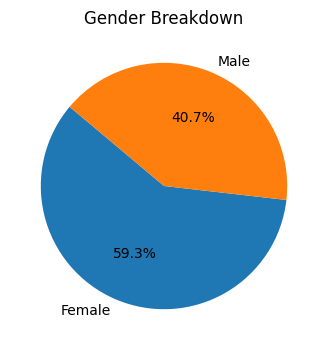

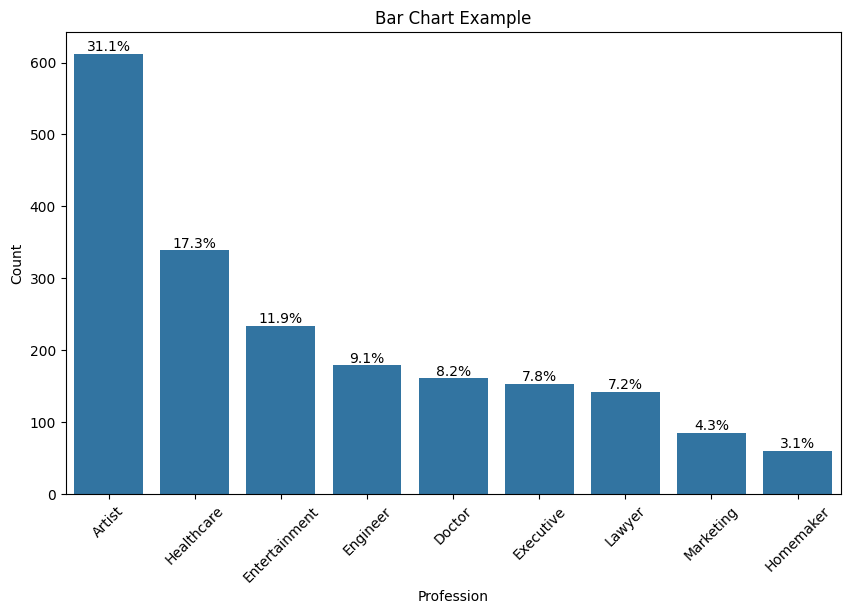

In [19]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Lets understand the Gender Breakdown of the Business

gender_counts = df['Gender'].value_counts() # First make a count of genders so we can visualize 

plt.figure(figsize=(4, 4))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Breakdown')
plt.show()

profession_count = df['Profession'].value_counts().reset_index()
profession_count.columns = ['Profession', 'Count']

# Calculate the percentage of total for each profession
total_count = profession_count['Count'].sum()
profession_count['Percentage'] = (profession_count['Count'] / total_count) * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Profession', y='Count', data=profession_count)
plt.title('Bar Chart Example')
plt.xlabel('Profession')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels if necessary for better readability

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total_count)
    ax.text(p.get_x() + p.get_width() / 2., height, percentage, ha='center', va='bottom')

plt.show()